# 아웃포커싱 효과가 적용된 인물모드 사진 실험

# 실험

### import 라이브러리

In [1]:
import os
import urllib
import cv2
import numpy as np
from pixellib.semantic import semantic_segmentation
from matplotlib import pyplot as plt

In [2]:
img_dir = "./project-images"
img_person_path = f"{img_dir}/사람과토끼.png"
img_bird_path = f"{img_dir}/탄천의새.png"

imgs_path = [img_person_path,img_bird_path]

### 이미지를 imread로 읽어서 저장

In [3]:
# 3개의 이미지를 imread로 읽어서 리스트로 저장할 변수
imgs_orig = []

for img_path in imgs_path:
    img_orig = cv2.imread(img_path)
    imgs_orig.append(img_orig)

In [4]:
# imread로 읽어온 이미지를 입력받아 확인하는 함수
def check_img(img):
    print(img.shape)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.show()

(1280, 960, 3)


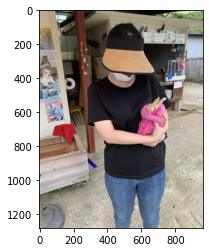

(1280, 960, 3)


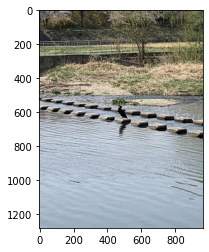

In [5]:
# 이미지 확인
for img in imgs_orig:
    check_img(img)

### 모델 가져오기

In [6]:
#  노드에서 저장한 모델 파이을 사용
model_dir = os.getenv('HOME')+'/aiffel/human_segmentation/models' 
model_file = os.path.join(model_dir, 'deeplabv3_xception_tf_dim_ordering_tf_kernels.h5') 
# PixelLib의 semantic_segmentation 클래스를 인스턴스화
model = semantic_segmentation() 

# 사전 학습된 모델을 PASCAL VOC 데이터셋으로 학습한 모델 가중치와 함께 추론에 사용할 준비를 함
model.load_pascalvoc_model(model_file) 

### 객체 탐지

In [7]:
# 이미지 path를 입력받아 segvalues, output으로 출력

segmented_list = []
for path in imgs_path:
    segvalues, output = model.segmentAsPascalvoc(path)
    segmented_list.append((segvalues,output))

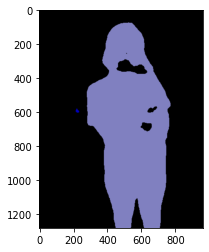

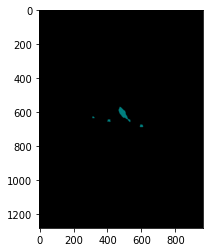

In [8]:
for _, output in segmented_list:
    plt.imshow(output)
    plt.show()

=> 토끼를 앉고 있는 사람에서, 토끼부분은 사람으로 인식되지 않는 것을 알 수 있다.  
새는 이미지 대비해서 매우 작은 부분임에도 인식이 가능한 것이 놀랍다.  

In [9]:
LABEL_NAMES = [
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
]

### 이미지 마스킹 작업

#### 사전작업: label별 컬러맵 만들기

In [10]:
#컬러맵 만들기 
colormap = np.zeros((256, 3), dtype = int)
ind = np.arange(256, dtype=int)

for shift in reversed(range(8)):
    for channel in range(3):
        colormap[:, channel] |= ((ind >> channel) & 1) << shift
    ind >>= 3

colormap[:20] #생성한 20개의 컬러맵 출력

array([[  0,   0,   0],
       [128,   0,   0],
       [  0, 128,   0],
       [128, 128,   0],
       [  0,   0, 128],
       [128,   0, 128],
       [  0, 128, 128],
       [128, 128, 128],
       [ 64,   0,   0],
       [192,   0,   0],
       [ 64, 128,   0],
       [192, 128,   0],
       [ 64,   0, 128],
       [192,   0, 128],
       [ 64, 128, 128],
       [192, 128, 128],
       [  0,  64,   0],
       [128,  64,   0],
       [  0, 192,   0],
       [128, 192,   0]])

In [11]:
LABEL_NAMES.index('person')

15

In [12]:
# 사람은 15에 해당, 사람의 컬러코드 확인
colormap[15]

array([192, 128, 128])

In [13]:
LABEL_NAMES.index('bird')

3

In [14]:
# 새는 3에 해당, 새의 컬러코드 확인
colormap[3]

array([128, 128,   0])

#### 사전작업: bgr 코드를 rgb 코드로 변경후, seg_color로 저장

In [15]:
colormap[15][::-1]

array([128, 128, 192])

In [16]:
person_seg_color = colormap[15][::-1].astype(np.uint8)
person_seg_color

array([128, 128, 192], dtype=uint8)

In [17]:
bird_seg_color = colormap[3][::-1].astype(np.uint8)
bird_seg_color

array([  0, 128, 128], dtype=uint8)

#### 마스킹 작업

In [18]:
# output과 seg_color를 입력받아 탐지한 객체는 True, 그 이외는 False로 masking하는 함수, 마스킹 작업이 완료된 이미지를 반환
def masking(output, seg_color):
    img_masked = np.all(output == seg_color, axis=-1)
    return img_masked    

In [19]:
len(segmented_list)

2

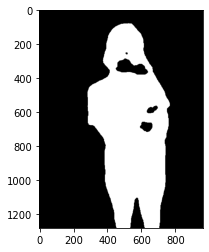

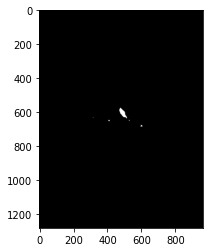

In [26]:
# 마스킹 작업 후의 이미지들을 저장, 확인
imgs_masked_tf = []
for (_, output), seg_color in zip(segmented_list, (person_seg_color,bird_seg_color)):
    img_masked = masking(output, seg_color)
    imgs_masked_tf.append(img_masked)
    plt.imshow(img_masked, cmap='gray')
    plt.show()

In [27]:
img_mask_color_list = []
# False, True 데이터를 0, 1 로 변환후 0, 255로 변환
# astype(np.uint8)로 형 변환 → True → 1, False → 0
# * 255 → True는 255(흰색), False는 0(검정)
for img_true_false in imgs_masked_tf:
    img_mask = img_true_false.astype(np.uint8) * 255
    img_mask_color = cv2.cvtColor(img_mask, cv2.COLOR_GRAY2BGR)
    img_mask_color_list.append(img_mask_color)

### 블러 처리된 이미지로 만들기

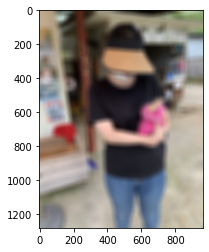

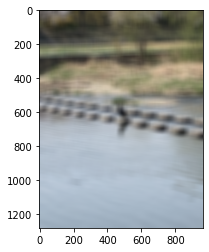

In [28]:
#  블러 처리된 이미지 저장
imgs_orig_blur = []
for img in imgs_orig:
    img_orig_blur = cv2.blur(img, (40,40))
    
    imgs_orig_blur.append(img_orig_blur)
    
    plt.imshow(cv2.cvtColor(img_orig_blur, cv2.COLOR_BGR2RGB))
    plt.show()

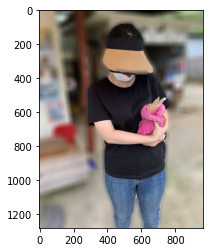

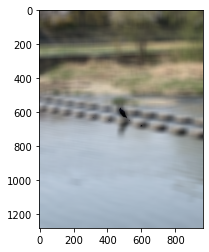

In [29]:
for img_mask_color, img_orig, img_blur in zip(img_mask_color_list,imgs_orig, imgs_orig_blur):
    img_concat = np.where(img_mask_color==255, img_orig, img_blur)
    plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
    plt.show()

# 프로젝트 코드

## 함수로 만들어서 처리

In [52]:
# image 경로, 추론준비가 된 모델 를 넣으면 아웃 포커싱 이미지를 출력
def get_out_focusing_image(path, model, target="person", background=False):
    print("get image origin")
    # 원봉 이미지 저장, bgr 형식
    img_orig = cv2.imread(path)
    
    # 시각화 확인: 원본 이미지 출력
    plt.imshow(cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB))
    plt.show()
    
    print("start segmentation")
    # 모델로 segmentation 
    segvalues, output = model.segmentAsPascalvoc(path)
    
    # 시각화 확인: segmentation 된 이미지 출력
    plt.imshow(output)
    plt.show()
    
    print("start masking")
    # 마스킹 작업
    target_index = LABEL_NAMES.index(target)
    
    seg_color = colormap[target_index][::-1].astype(np.uint8)
    print(f"{target=}클래스에 초점을 맞춥니다: {seg_color=}")
    
    img_mask_tf = np.all(output == seg_color, axis=-1)
    
    # 시각화 확인   
    plt.imshow(img_mask_tf, cmap='gray')
    plt.show()
    
    # 마스킹 데이터 변환
    img_mask = img_mask_tf.astype(np.uint8) * 255
    img_mask_color = cv2.cvtColor(img_mask, cv2.COLOR_GRAY2BGR)
    
    print("make blur image")
    # 블러 처리된 이미지 만들기
    img_orig_blur = cv2.blur(img_orig, (40,40))
    
    # 시각화 확인
    plt.imshow(cv2.cvtColor(img_orig_blur, cv2.COLOR_BGR2RGB))
    plt.show()
    
    # 블렌드 합성
    img_concat = np.where(img_mask_color==255, img_orig, img_orig_blur)
    plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
    plt.show()
    
    if background:
        back_img = cv2.imread(background)
        
        # 배경 이미지 크기를 원본 이미지 크기에 맞게 리사이즈
        back_img = cv2.resize(back_img, (img_orig.shape[1], img_orig.shape[0]))

        # background와 블렌드 합성
        img_concat = np.where(img_mask_color==255, img_orig, back_img)
        plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
        plt.show()
    

get image origin


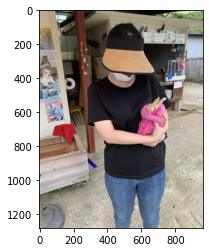

start segmentation


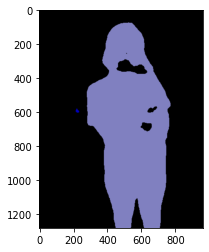

start masking
target='person'클래스에 초점을 맞춥니다: seg_color=array([128, 128, 192], dtype=uint8)


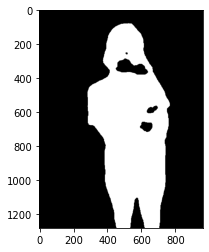

make blur image


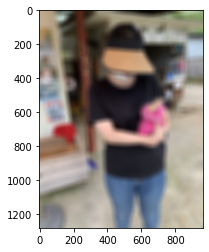

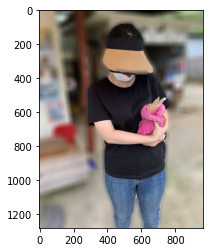

In [31]:
get_out_focusing_image(img_person_path, model)

get image origin


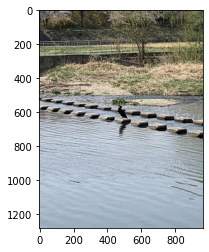

start segmentation


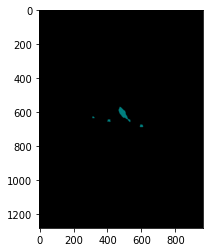

start masking
target='bird'클래스에 초점을 맞춥니다: seg_color=array([  0, 128, 128], dtype=uint8)


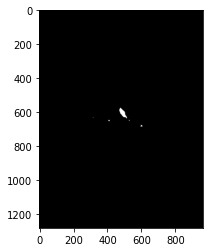

make blur image


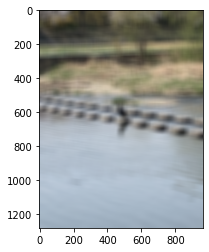

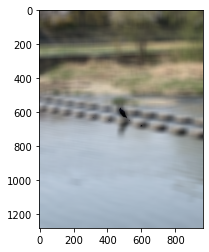

In [33]:
get_out_focusing_image(img_bird_path, model, target="bird")

### 사진 추가

In [43]:
cat1_path = f"{img_dir}/IMG_3252.png"
cat2_path = f"{img_dir}/IMG_3253.png"
chair_path = f"{img_dir}/"

get image origin


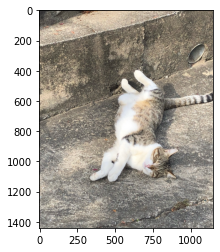

start segmentation


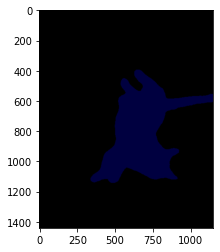

start masking
target='cat'클래스에 초점을 맞춥니다: seg_color=array([ 0,  0, 64], dtype=uint8)


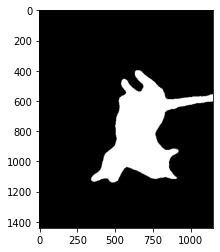

make blur image


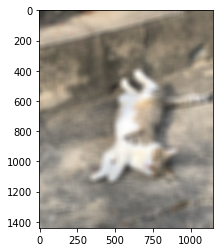

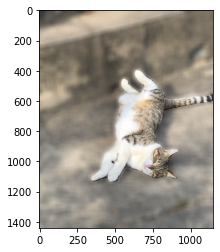

In [44]:
get_out_focusing_image(cat1_path, model, target="cat")

background 합성

In [48]:
background = f"{img_dir}/IMG_3256.png"

get image origin


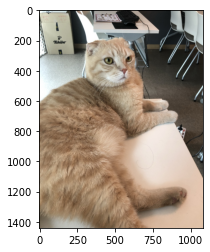

start segmentation


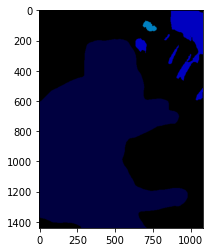

start masking
target='cat'클래스에 초점을 맞춥니다: seg_color=array([ 0,  0, 64], dtype=uint8)


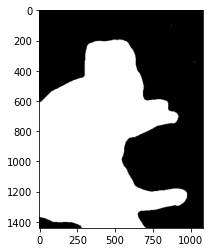

make blur image


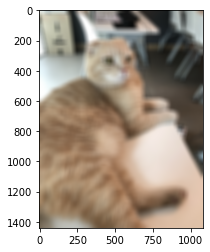

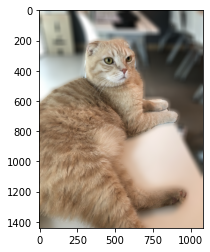

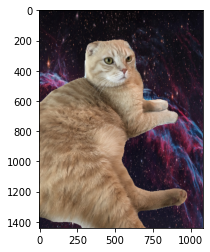

In [53]:
get_out_focusing_image(cat2_path, model, target="cat", background=background)

# 회고

- 우선 내가 실험함 사진들에서는 이상한 부분을 찾지 못 했다. 내가 눈썰미가 부족한 것 같다고 생각이 든다.  
- 사진에 대한 이해가 너무 부족해 프로젝트 진행하는데 어려웠다.
- 사진에서 매우 작은 오브젝트에(새 사진)에 대해서는 semantic segmentation은 이루어졌지만, 합성을 해보니, 새의 오브젝트 부분에서도 선명해지지 않은 것이 합성을 잘못해서 인지, 너무 작은 물체여서 그런지 잘 모르겠다. 
  
---
- 인물 모드 사진의 문제점을 개선하는 방법
    > 내가 생각했을 때는 오브젝트 경계부분에서 segmentation이 잘 이루어지지 않는 것 같은데,  
    > 이 부분을 개선할 방법으로 조사해본 방법은 'Conditional Random Field (CRF)' 이다.  
    > CRF는 확률 그래프 모델의 일종으로, 각 픽셀의 레이블 간 상관관계를 고려하여 예측값을 보정하는 방법이다.  
    > 인접한 픽셀, 색상 유사도, 공간적 거리 등을 고려해서 더 자연스러운 경계와 더 부드러운 예측를 하는 하는 것이다.  
    > 이 방법은 네트워크의 구성이 아니고, softmax 결과가 나온 후, 후처리를 진행한다.